In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import pandas as pd
from matplotlib import pylab

params = {'xtick.labelsize': 18,
 'ytick.labelsize': 18,
 'axes.titlesize' : 22,
 'axes.labelsize' : 20,
 'legend.fontsize': 18,
 'legend.title_fontsize': 22,
 'figure.titlesize': 24
 }
pylab.rcParams.update(params)

Loading the data, and getting its shape.

In [2]:
df = pd.read_csv('virus_data.csv')
df.shape


(2500, 28)

Getting some info about the num_of_siblings feature

In [3]:
df.num_of_siblings.value_counts()

1.0    786
2.0    553
0.0    544
3.0    318
4.0    120
5.0     34
6.0      9
7.0      1
8.0      1
9.0      1
Name: num_of_siblings, dtype: int64

Splitting the data into train and test set

In [4]:
X = df.drop(['covid', 'risk', 'spread'], axis=1)
Y = df[['covid', 'risk', 'spread']]
'''
X_train: features of the training set
Y_train: labels of the training set
X_test: features of the testing set
Y_test: labels of the testing set
'''
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y,test_size=0.2, train_size=0.8, random_state=139)
X_train.join(Y_train).to_csv('final_dataset.csv')

Computing some correlation measurements about our data.

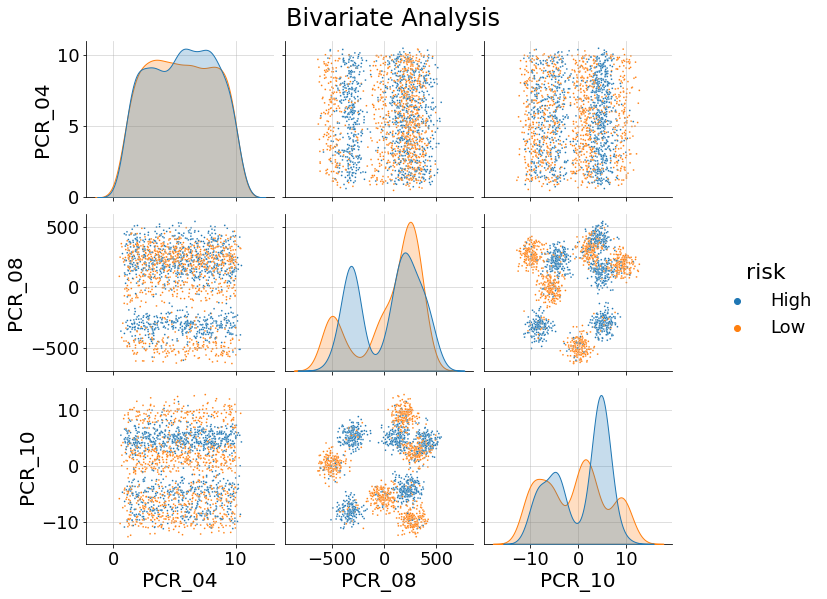

In [6]:
import seaborn as sns
import sklearn.preprocessing
df_train = pd.concat([X_train,Y_train], axis = 1)
g=sns.pairplot(df_train[['PCR_04','PCR_08', 'PCR_10', 'risk']],hue ='risk', plot_kws={"s": 3})
g.fig.suptitle("Bivariate Analysis ", y=1.04)
for ax in np.ravel(g.axes):
 ax.grid(alpha=0.5)
g.fig.set_size_inches(12,8)

In [7]:
from sklearn.base import BaseEstimator,ClassifierMixin
from scipy.spatial import distance
from scipy.stats import mode

class kNN(BaseEstimator, ClassifierMixin):
 def __init__(self, n_neighbors:int = 5):
  self.n_neighbors = n_neighbors
 def fit(self, X, y):
  # TODO: complete
  self.X = X
  self.y = y
  return self
 def predict(self, X):
  # Note: You can use self.n_neighbors here
  # TODO: compute the predicted labels (+1 or -1)

  #      self.x: (n1,n2)
  #           X: (m1,m2)
  # predictions: (m1,n1)
  predictions = distance.cdist(X,self.X,'euclidean')
  # k_indices:   (m1*n_neighbors)
  # we use flatten in order to be able to index self.y
  k_indices = (np.argpartition(predictions,self.n_neighbors,axis=1)[:,:self.n_neighbors]).flatten()
  predictions,_ = mode((self.y.iloc[k_indices]).values.reshape(X.shape[0], self.n_neighbors),1)
  return predictions

In [8]:
temp_X = X_train[['PCR_08','PCR_10']]
temp_Y = Y_train[['risk']].replace({'High':1, 'Low':-1})

k1 = kNN(1).fit(temp_X,temp_Y)
k9 = kNN(9).fit(temp_X,temp_Y)

print(k1.score(temp_X,temp_Y))
print(k9.score(temp_X,temp_Y))

1.0
0.8355


In [9]:
def visualize_clf(clf, X, Y, title, marker_size=150,
                  grid_length=300):
 import matplotlib.pyplot as plt
 from matplotlib.colors import ListedColormap

 plt.figure(figsize=(8, 8))

 # Parameters
 n_classes = 2
 markers = ["P", "v"]
 palette = sns.color_palette("hls", 2)
 custom_cmap = ListedColormap(palette.as_hex())
 #plot_step = 0.02

 x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
 y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
 x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
 y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
 xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                      np.linspace(y_min, y_max, grid_length))
 plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

 Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
 Z = Z.reshape(xx.shape)

 cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

 plt.xlabel("$x_1$")
 plt.ylabel("$x_2$")
 plt.grid(alpha=0.75)

 # Plot the training points
 for i, color, marker in zip(range(n_classes), palette, markers):
  idx = np.where(Y == i)
  plt.scatter(X[idx, 0], X[idx, 1], color=color,
              marker=marker,
              edgecolor='white', s=marker_size)

 plt.title(title, fontsize=20)
 plt.axis("tight")
 plt.show()

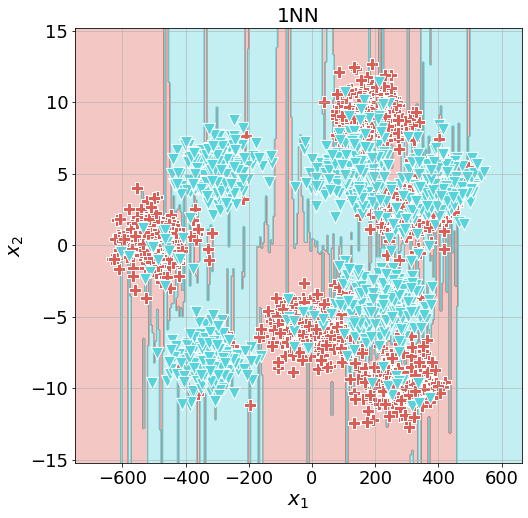

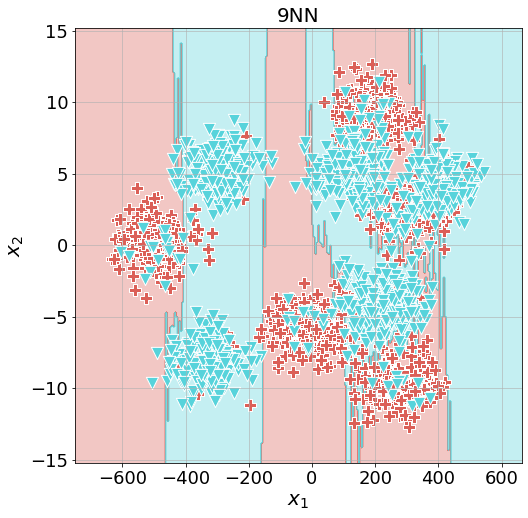

In [10]:
temp_Y = temp_Y.replace(-1,0)

visualize_clf(k1,temp_X.values,temp_Y.values,'1NN')
visualize_clf(k9,temp_X.values,temp_Y.values,'9NN')

0.8725


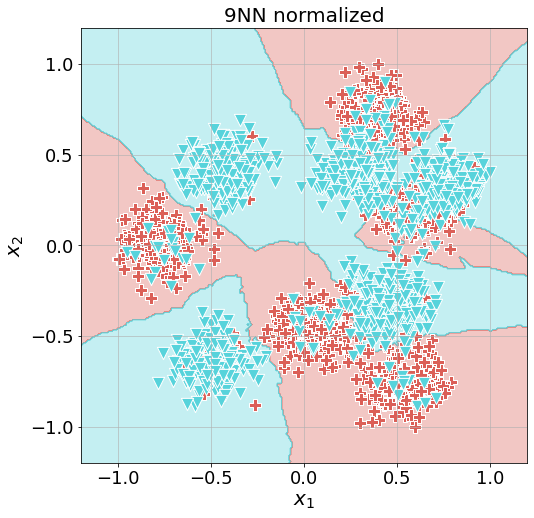

'\nTODO: run the knn on the scaled data.\n'

In [11]:
from sklearn.preprocessing import MinMaxScaler

normalized_X = MinMaxScaler((-1,1)).fit_transform(temp_X)
normalized_k9 = kNN(9).fit(normalized_X,temp_Y)

print(normalized_k9.score(normalized_X,temp_Y))
visualize_clf(normalized_k9,normalized_X,temp_Y.values,'9NN normalized')
'''
TODO: run the knn on the scaled data.
'''

In [12]:

X_train_encoded = pd.get_dummies(X_train,columns=['blood_type'])

Here we will encode the symptoms feature.

In [13]:
#Transform the string to a list of symptoms.
def split(s):
 l = None
 if not pd.isna(s):
  l = s.split(';')
 else:
  l = ['NaN']
 return l

#Get every type of symptoms.
def get_items(df):
 s = set()
 for item in df:
  for value in item:
   s.add(value)
 return list(s)


symptoms_as_list_df = X_train_encoded['symptoms'].apply(split)
items = get_items(symptoms_as_list_df)

In [14]:
#Transform a column containing list to a boolean df
def boolean_df(item_lists, unique_items):
 bool_dict = {}
 for i, item in enumerate(unique_items):
  bool_dict[item] = item_lists.apply(lambda x: int(item in x))
 return pd.DataFrame(bool_dict)

#Create the boolean df
symptoms_df = boolean_df(symptoms_as_list_df, items)
symptoms_df = symptoms_df.drop(['NaN'], axis=1)

#Join it the training set and drop the old symptoms col
X_train_encoded2 = X_train_encoded.join(symptoms_df)
X_train_encoded2 = X_train_encoded2.drop(['symptoms'], axis=1)



Here we will encode the Sex feature.

In [15]:

X_train_encoded3 = pd.get_dummies(X_train_encoded2, columns = ['sex'])

In [16]:
def clean_location(s: str):
 if pd.isna(s):
  return [0.,0.]
 else:
  s = s.replace('(','').replace(')','').replace('\'', '').replace(' ','')
  s = s.split(',')
  s = [float(v) for v in s]
  return s


Here we will encode the location to X,Y,has_location

In [17]:
loc_df = pd.DataFrame(X_train_encoded3['current_location'].apply(clean_location).to_list(), columns=['X', 'Y'])
X_train_encoded4 = X_train_encoded3.join(loc_df).drop(['current_location'], axis=1)


Here we will transform the date into three columns day/month/year

In [18]:
def convert_date(s: str):
 if pd.isna(s):
  return [s,s,s]
 else:
  s = s.split('-')
  s = [int(v) for v in s]
  return s

date_df = pd.DataFrame(X_train_encoded4['pcr_date'].apply(convert_date).to_list(), columns=['day', 'month', 'year'])
X_train_encoded5 = X_train_encoded4.join(date_df).drop(['pcr_date'], axis = 1)
X_train_encoded5


,patient_id,age,weight,address,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,...,cough,fever,sore_throat,sex_F,sex_M,X,Y,day,month,year
454,4264,28.0,57.5,"99918 Timothy Pass Suite 249\nNew Heather, AK ...",2.0,3.0,159.60,2.0,68.0,0.0,...,0,0,0,1,0,48.73218,11.18709,10.0,6.0,21.0
316,7409,7.0,16.3,"30939 Barnett Isle\nHunterville, MD 51799",2.0,7.0,441.80,2.0,56.0,2.0,...,0,0,0,0,0,42.81390,-1.64295,9.0,2.0,20.0
2172,2925,36.0,57.7,"656 Ross Views\nPort Laura, IA 30789",1.0,8.0,595.80,3.0,91.0,3.0,...,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN
1315,7186,36.0,58.9,"128 Carter Shores Suite 787\nLake Andrew, NJ 7...",3.0,6.0,67.70,1.0,84.0,3.0,...,0,0,0,1,0,32.50611,120.14278,2.0,3.0,20.0
1392,3464,60.0,48.3,"29614 Bobby Loop Apt. 971\nDanielborough, MO 8...",NaN,NaN,287.90,6.0,93.0,0.0,...,0,0,1,0,1,55.85000,37.56667,29.0,7.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1208,9.0,56.9,"61075 David Springs\nPearsonhaven, TX 08189",4.0,4.0,466.10,6.0,95.0,1.0,...,0,1,0,0,1,35.82756,137.95378,17.0,11.0,20.0
705,3487,52.0,66.0,"846 Hall Alley Apt. 247\nGatesfurt, MS 67896",1.0,6.0,214.08,2.0,57.0,1.0,...,0,0,0,0,1,50.50301,13.63617,24.0,3.0,20.0
524,2438,46.0,62.2,"9421 Hubbard Forest Suite 543\nSouth David, ME...",2.0,6.0,423.84,6.0,103.0,2.0,...,0,0,0,1,0,34.61667,135.60000,14.0,2.0,20.0
1908,7422,13.0,42.7,"90961 Smith Village Apt. 041\nWest Jeanette, L...",0.0,5.0,161.50,1.0,57.0,1.0,...,0,0,0,1,0,20.88197,85.83334,25.0,8.0,20.0


Here we will remove the address column

In [19]:
X_train_final = X_train_encoded5.drop(['address'], axis=1)
X_train_final

,patient_id,age,weight,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,PCR_01,...,cough,fever,sore_throat,sex_F,sex_M,X,Y,day,month,year
454,4264,28.0,57.5,2.0,3.0,159.60,2.0,68.0,0.0,-0.768653,...,0,0,0,1,0,48.73218,11.18709,10.0,6.0,21.0
316,7409,7.0,16.3,2.0,7.0,441.80,2.0,56.0,2.0,-0.333669,...,0,0,0,0,0,42.81390,-1.64295,9.0,2.0,20.0
2172,2925,36.0,57.7,1.0,8.0,595.80,3.0,91.0,3.0,-0.252081,...,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN
1315,7186,36.0,58.9,3.0,6.0,67.70,1.0,84.0,3.0,-0.237568,...,0,0,0,1,0,32.50611,120.14278,2.0,3.0,20.0
1392,3464,60.0,48.3,NaN,NaN,287.90,6.0,93.0,0.0,NaN,...,0,0,1,0,1,55.85000,37.56667,29.0,7.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1208,9.0,56.9,4.0,4.0,466.10,6.0,95.0,1.0,-1.015654,...,0,1,0,0,1,35.82756,137.95378,17.0,11.0,20.0
705,3487,52.0,66.0,1.0,6.0,214.08,2.0,57.0,1.0,0.466248,...,0,0,0,0,1,50.50301,13.63617,24.0,3.0,20.0
524,2438,46.0,62.2,2.0,6.0,423.84,6.0,103.0,2.0,0.259871,...,0,0,0,1,0,34.61667,135.60000,14.0,2.0,20.0
1908,7422,13.0,42.7,0.0,5.0,161.50,1.0,57.0,1.0,-0.425232,...,0,0,0,1,0,20.88197,85.83334,25.0,8.0,20.0


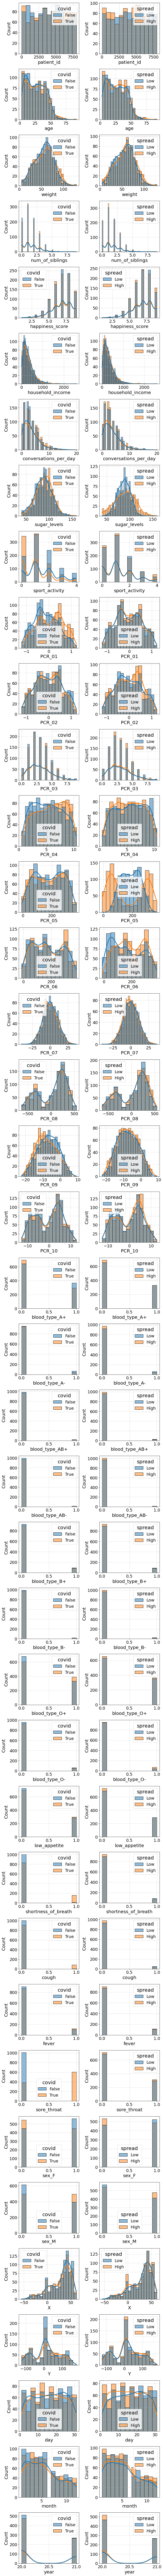

In [20]:
df_plot = X_train_final.join(Y_train)

COL_NAME = X_train_final.columns
COLS = 2
ROWS = len(COL_NAME)
plt.figure(figsize=(5 * COLS, 4 * ROWS))
for row in range(ROWS):
 column = COL_NAME[row]
 plt.subplot(ROWS,COLS, row * COLS + 1)
 sns.histplot(data=df_plot, x=column, hue="covid", line_kws={"linewidth": 3},
              kde=("float" in df_plot[column].dtype.name))
 plt.grid(alpha=0.5)
 plt.subplot(ROWS,COLS, row * COLS + 2)
 sns.histplot(data=df_plot, x=column, hue="spread", line_kws={"linewidth": 3},
              kde=("float" in df_plot[column].dtype.name))
 plt.grid(alpha=0.5)
plt.tight_layout()

In [21]:
df_plot = df_plot.replace({'High': 1, 'Low': 0,True: 1, False:0})
s = df_plot.corr().spread.abs()
most_correlated_features = list(s.sort_values(kind="quicksort", ascending=False).head(6).index)
s.sort_values(kind="quicksort", ascending=False).head(11)


spread           1.000000
PCR_06           0.128574
PCR_05           0.089266
sugar_levels     0.065011
blood_type_O-    0.058407
sex_F            0.053136
day              0.051605
PCR_10           0.050615
sex_M            0.047298
PCR_04           0.044104
PCR_07           0.041577
Name: spread, dtype: float64

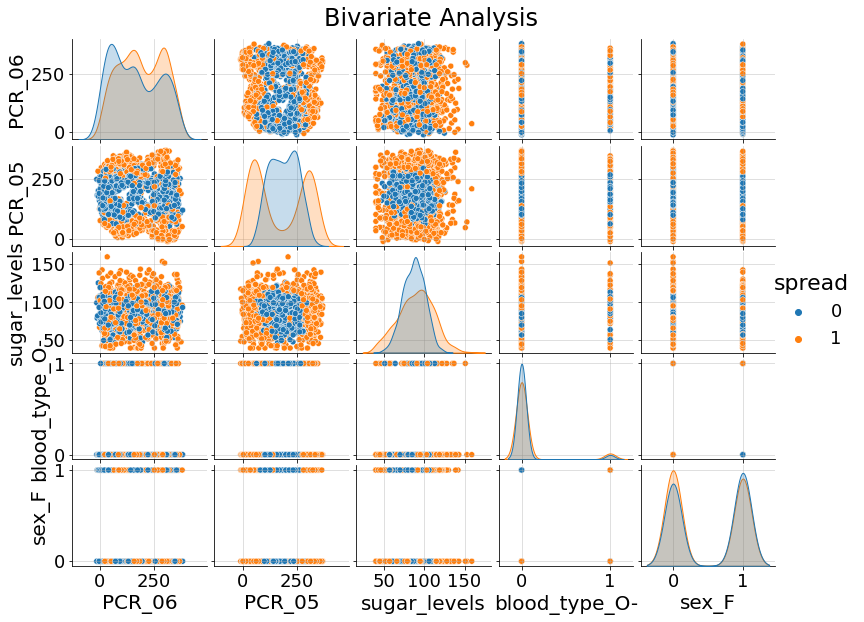

In [22]:

g=sns.pairplot(df_plot[most_correlated_features],hue ='spread')
g.fig.suptitle("Bivariate Analysis ", y=1.04)
for ax in np.ravel(g.axes):
 ax.grid(alpha=0.5)
g.fig.set_size_inches(12,8)

In [23]:
assert type(X_train_final) is pd.DataFrame
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 454 to 1540
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             2000 non-null   int64  
 1   age                    1905 non-null   float64
 2   weight                 1886 non-null   float64
 3   num_of_siblings        1901 non-null   float64
 4   happiness_score        1907 non-null   float64
 5   household_income       1897 non-null   float64
 6   conversations_per_day  1910 non-null   float64
 7   sugar_levels           1898 non-null   float64
 8   sport_activity         1892 non-null   float64
 9   PCR_01                 1905 non-null   float64
 10  PCR_02                 1907 non-null   float64
 11  PCR_03                 1912 non-null   float64
 12  PCR_04                 2000 non-null   float64
 13  PCR_05                 1887 non-null   float64
 14  PCR_06                 1910 non-null   float64
 15  PC

Here we replace the PCR nan values by the median of the column

In [24]:

for i in range(1,10):
 X_train_final[f'PCR_0{i}'] = X_train_final[f'PCR_0{i}'].fillna(X_train_final[f'PCR_0{i}'].median())


Here we replace the missing days, months and year by random dates in the interval [01-01-2020; 31-12-2021]

In [25]:
from random import randrange
X_train_final['day'] = X_train_final['day'].fillna(randrange(1,31))
X_train_final['month'] = X_train_final['month'].fillna(randrange(1,12))
X_train_final['year'] = X_train_final['year'].fillna(randrange(20,21))

X_train_final

,patient_id,age,weight,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,PCR_01,...,cough,fever,sore_throat,sex_F,sex_M,X,Y,day,month,year
454,4264,28.0,57.5,2.0,3.0,159.60,2.0,68.0,0.0,-0.768653,...,0,0,0,1,0,48.73218,11.18709,10.0,6.0,21.0
316,7409,7.0,16.3,2.0,7.0,441.80,2.0,56.0,2.0,-0.333669,...,0,0,0,0,0,42.81390,-1.64295,9.0,2.0,20.0
2172,2925,36.0,57.7,1.0,8.0,595.80,3.0,91.0,3.0,-0.252081,...,0,0,0,1,0,NaN,NaN,5.0,11.0,20.0
1315,7186,36.0,58.9,3.0,6.0,67.70,1.0,84.0,3.0,-0.237568,...,0,0,0,1,0,32.50611,120.14278,2.0,3.0,20.0
1392,3464,60.0,48.3,NaN,NaN,287.90,6.0,93.0,0.0,-0.044367,...,0,0,1,0,1,55.85000,37.56667,29.0,7.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1208,9.0,56.9,4.0,4.0,466.10,6.0,95.0,1.0,-1.015654,...,0,1,0,0,1,35.82756,137.95378,17.0,11.0,20.0
705,3487,52.0,66.0,1.0,6.0,214.08,2.0,57.0,1.0,0.466248,...,0,0,0,0,1,50.50301,13.63617,24.0,3.0,20.0
524,2438,46.0,62.2,2.0,6.0,423.84,6.0,103.0,2.0,0.259871,...,0,0,0,1,0,34.61667,135.60000,14.0,2.0,20.0
1908,7422,13.0,42.7,0.0,5.0,161.50,1.0,57.0,1.0,-0.425232,...,0,0,0,1,0,20.88197,85.83334,25.0,8.0,20.0


Here we will replace the values of age, weight, num_of_siblings, happiness_score, household_income, conversation_per_day, sugar_levels and sport_activity by the median of the column.

In [26]:
cont_cols = X_train_final.columns[1:9]

for col in cont_cols:
 X_train_final[col] = X_train_final[col].fillna(X_train_final[col].median())


Here we will replace the coordinate X and Y by random values in the same range than the present values in the data

In [27]:
from random import random

min_longitude,max_longitude = X_train_final.X.describe()[['min','max']]
min_latitude, max_latitude = X_train_final.Y.describe()[['min','max']]

X_train_final['X'] = X_train_final['X'].fillna(random()*(max_latitude - min_latitude) + min_latitude)
X_train_final['Y'] = X_train_final['Y'].fillna(random()*(max_latitude - min_latitude) + min_latitude)


[]

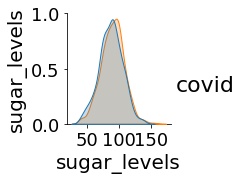

In [28]:
g=sns.pairplot(df_plot[['sugar_levels','covid']],hue ='covid')
plt.plot()



In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_train_scaled = X_train_final.copy()


min_max_cols = ['day', 'month', 'year']
standard_col = ['age', 'weight', 'num_of_siblings', 'happiness_score',
                'household_income', 'conversations_per_day', 'sugar_levels',
                'sport_activity', 'PCR_01', 'PCR_02', 'PCR_03',
                'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10', 'X', 'Y']


for col in min_max_cols:
 MM_scaler = MinMaxScaler()
 X_train_scaled[[col]] = MM_scaler.fit_transform(X_train_final[[col]])
for col in standard_col:
 Std_scaler = StandardScaler()
 X_train_scaled[col] = Std_scaler.fit_transform(X_train_final[[col]])


X_train_scaled

,patient_id,age,weight,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,PCR_01,...,cough,fever,sore_throat,sex_F,sex_M,X,Y,day,month,year
454,4264,0.104085,0.022012,0.408940,-2.735628,-0.590433,-0.531203,-1.144019,-1.135404,-1.331345,...,0,0,0,1,0,1.007111,-0.243797,0.300000,0.454545,1.0
316,7409,-1.282831,-1.923045,0.408940,0.042364,0.511629,-0.531203,-1.819156,0.719074,-0.544829,...,0,0,0,0,0,0.833350,-0.422399,0.266667,0.090909,0.0
2172,2925,0.632434,0.031454,-0.400843,0.736863,1.113038,-0.177892,0.149993,1.646312,-0.397306,...,0,0,0,1,0,-1.588851,0.861914,0.133333,0.909091,0.0
1315,7186,0.632434,0.088106,1.218723,-0.652134,-0.949326,-0.884514,-0.243837,1.646312,-0.371064,...,0,0,0,1,0,0.530712,1.272938,0.033333,0.181818,0.0
1392,3464,2.217481,-0.412321,-0.400843,0.042364,-0.089389,0.882041,0.262516,-1.135404,-0.021728,...,0,0,1,0,1,1.216091,0.123425,0.933333,0.545455,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1208,-1.150744,-0.006314,2.028506,-2.041130,0.606527,0.882041,0.375038,-0.208165,-1.777960,...,0,1,0,0,1,0.628230,1.520879,0.533333,0.909091,0.0
705,3487,1.689132,0.423298,-0.400843,-0.652134,-0.377675,-0.531203,-1.762894,-0.208165,0.901541,...,0,0,0,0,1,1.059103,-0.209704,0.766667,0.181818,0.0
524,2438,1.292870,0.243899,0.408940,-0.652134,0.441491,0.882041,0.825130,0.719074,0.528380,...,0,0,0,1,0,0.592678,1.488113,0.433333,0.090909,0.0
1908,7422,-0.886570,-0.676698,-1.210626,-1.346632,-0.583013,-0.884514,-1.762894,-0.208165,-0.710387,...,0,0,0,1,0,0.189426,0.795328,0.800000,0.636364,0.0


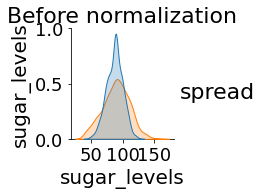

count    2000.000000
mean       88.334000
std        17.778624
min        40.000000
25%        77.000000
50%        89.000000
75%        99.250000
max       159.000000
Name: sugar_levels, dtype: float64


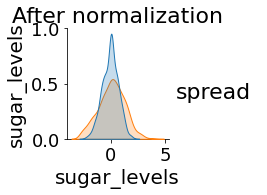

count    2.000000e+03
mean    -1.776357e-16
std      1.000250e+00
min     -2.719338e+00
25%     -6.376666e-01
50%      3.747008e-02
75%      6.141493e-01
max      3.975767e+00
Name: sugar_levels, dtype: float64


In [37]:
sns.pairplot(X_train_final.join(Y_train)[['sugar_levels', 'spread']], hue='spread')
plt.title('Before normalization')
plt.show()
print(X_train_final['sugar_levels'].describe())
sns.pairplot(X_train_scaled.join(Y_train)[['sugar_levels', 'spread']], hue='spread')
plt.title('After normalization')
plt.show()
print(X_train_scaled['sugar_levels'].describe())

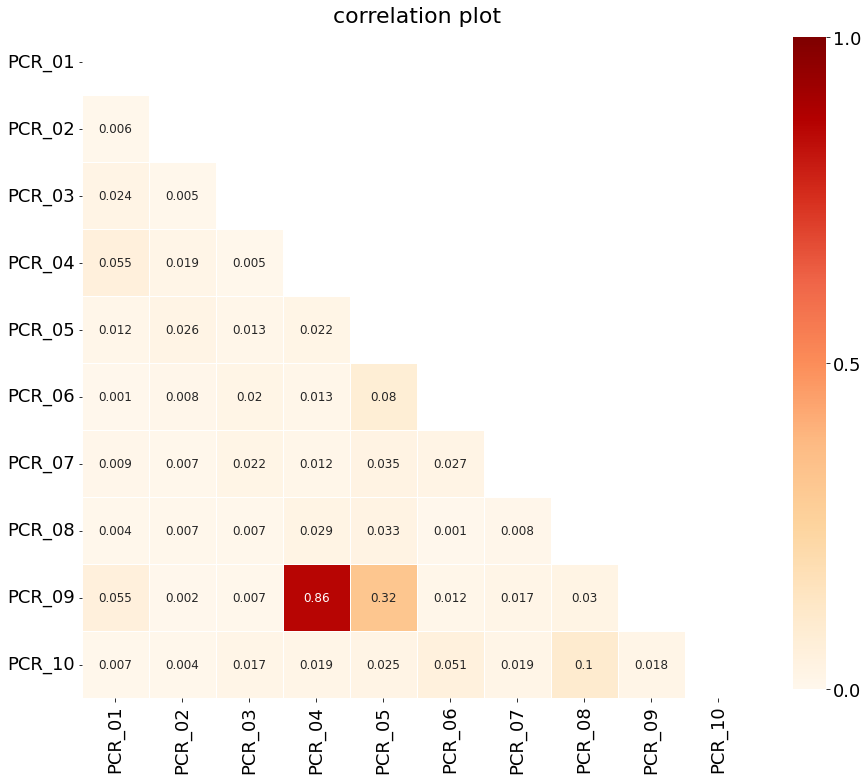

In [40]:

def plot_corr_matrix(df, title):
 corr_matrix = np.abs(df.corr()).round(decimals=3)

 mask = np.zeros_like(corr_matrix, dtype=bool)
 mask[np.triu_indices_from(mask)]= True

 f, ax = plt.subplots(figsize=(15, 20))
 heatmap = sns.heatmap(corr_matrix,
                       mask = mask,
                       square = True,
                       linewidths = .5,
                       cmap = "OrRd",
                       cbar_kws = {'shrink': .6, "ticks" : [0, 0.5, 1]},
                       vmin = 0,
                       vmax = 1,
                       annot = True,
                       annot_kws = {"size": 12})
 #add the column names as labels
 ax.set_title(title)
 ax.set_yticklabels(corr_matrix.columns, rotation = 0)
 ax.set_xticklabels(corr_matrix.columns)
 sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plot_corr_matrix(X_train_scaled.filter(like='PCR'), title='correlation plot')

In [32]:
def plot3d(df, colX, colY, colZ, hue=None):
  %matplotlib inline

  fig = plt.figure(figsize=(20, 5))
  axes = [fig.add_subplot(1, 4, 1, projection='3d'),
          fig.add_subplot(1, 4, 2, projection='3d'),
          fig.add_subplot(1, 4, 3, projection='3d'),
          fig.add_subplot(1, 4, 4, projection='3d')]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if hue is None:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)
    else:
      idx = df[hue] == True
      df1 = df[idx]
      df2 = df[~idx]

      ax.scatter3D(df1[colX], df1[colY], df1[colZ], color=palette[0], s=1)
      ax.scatter3D(df2[colX], df2[colY], df2[colZ], color=palette[1], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.tight_layout()
  plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


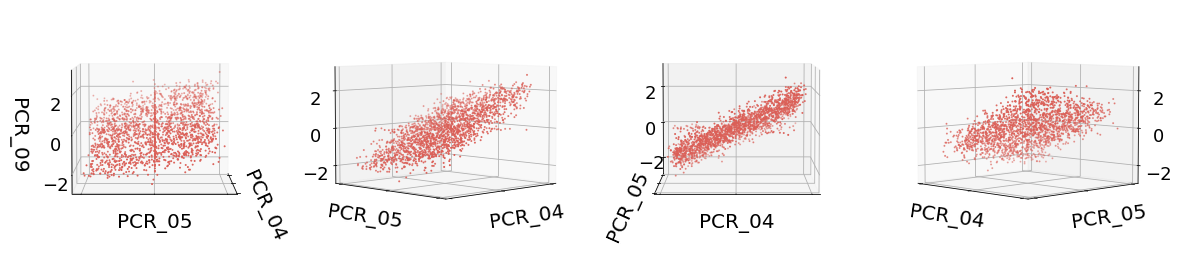

In [41]:
plot3d(X_train_scaled, 'PCR_04', 'PCR_05', 'PCR_09')

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector

knn = KNeighborsClassifier()
sfs = SequentialFeatureSelector(knn,n_features_to_select=2)
sfs.fit(X_train_scaled, Y_train.apply(lambda x: x == 'Low'))

{'cv': 5,
 'direction': 'forward',
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsClassifier(),
 'n_features_to_select': 2,
 'n_jobs': None,
 'scoring': None}

In [47]:
pd.DataFrame(sfs.get_feature_names_out(), columns=['best features'])

,best features
0,PCR_05
1,PCR_10
